The case of constant anisotropy in the velocity distribution of a dSphs stellar component is realised by the Charbonnier profile, which reads:
\begin{equation}
\beta(r)=\beta
\end{equation}

In this case, the projected line-of-sight velocity dispersion is given by:
\begin{equation}
\sigma^2_{l.o.s.}(R) = 2G\mu_0\frac{\gamma^{1-2\beta}}{I(R)} \int^\infty_1 \left(1-\frac{\beta}{z^2}\right)\frac{z^{1-2\beta}}{\sqrt{z^2-1}}\int^\infty_{z\gamma}y^{2\beta-2}\nu_\ast(y)\mu(y\alpha)dydz
\end{equation}
where $\gamma = \frac{R}{r_h}$ and $\alpha = \frac{r_h}{r_0}$

In [1]:
import yaml
import numpy as np
from os import mkdir
from sys import argv
from AT import get_data
from scipy import special
from matplotlib import pylab as plt
from scipy.integrate import quad
from math import sqrt,cos, log10, pi, isnan
from scipy import optimize as sciopt
from scipy.interpolate import UnivariateSpline as spline
from scipy.interpolate import interp1d as interp
from functions_simCA import integral2, Jfactor,nu
from multiprocessing import Pool
%matplotlib inline

In [2]:
homedir = '/home/andrea/Desktop/work/DWARF/Jvalue/test/'
casedir = ['Charb_Core_nonPlum','Charb_Core_Plum','Charb_Cusp_nonPlum','Charb_Cusp_Plum']

D=50.
theta=0.5
# enter size of Mock dataset (options 100,1000,10000)
MockSize = 100
# enter number of subsampling set (options 0 -> 9)
dset = 0
# enter model choice - cf. casedir (options 1,2,3,4)
mod = 3

In [3]:
# inverse hyperbolic cosecant (used for gamma* = 1 , non-Plum)
def inv_csch(x):
    return np.log(np.sqrt(1+x**-2.)+x**-1.)
# integrand of I(R) (used for gamma* = 0.1 , Plum)
def integrand_I(r,rh,R):
    return nu(r/rh)*r/np.sqrt(r**2-R**2)

# dwarf surface brightness profile
def I(R,rh):
    return 2*quad(integrand_I,R,+np.inf,args=(rh,R))[0] if mod == 2 or mod == 4 else \
rh**2*((2*rh**2+R**2)*inv_csch(R/rh)-rh*np.sqrt(rh**2+R**2))/(rh**2+R**2)**(3/2.)

In [18]:
# Mock data preparation
data = ['/data/gs100_bs050_rcrs100_rarcinf_core_0400mpc3_df_%i_%i.dat'%(MockSize,dset),      # OsipkMerr_Core_nonPlum
        '/data/gs010_bs050_rcrs100_rarcinf_core_0400mpc3_df_%i_%i.dat'%(MockSize,dset),      # OsipkMerr_Core_Plum
        '/data/gs100_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_%i_%i.dat'%(MockSize,dset),      # OsipkMerr_Cusp_nonPlum
        '/data/gs010_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_%i_%i.dat'%(MockSize,dset)]      # OsipkMerr_Cusp_Plum
err  = ['/data/gs100_bs050_rcrs100_rarcinf_core_0400mpc3_df_%i_%i_err.dat'%(MockSize,dset),  # OsipkMerr_Core_nonPlum
        '/data/gs010_bs050_rcrs100_rarcinf_core_0400mpc3_df_%i_%i_err.dat'%(MockSize,dset),  # OsipkMerr_Core_Plum
        '/data/gs100_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_%i_%i_err.dat'%(MockSize,dset),  # OsipkMerr_Cusp_nonPlum
        '/data/gs010_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_%i_%i_err.dat'%(MockSize,dset)]  # OsipkMerr_Cusp_Plum
x,y,z,vx,vy,vz = np.loadtxt(homedir+casedir[mod-1]+data[mod-1],unpack=True)
R = np.sqrt(x**2+y**2) # assumed direction of observation along z-axis for simplicity (as suggested on the Gaia wiki)
d = np.sqrt(x**2+y**2+(D-z)**2)
v = (x*vx+y*vy+(D-z)*vz)/d
# Errors (from mock data) preparation
Evx,Evy,Evz = np.loadtxt(homedir+casedir[mod-1]+err[mod-1],unpack=True,usecols=(3,4,5))
Ex,Ey,Ez = np.absolute(Evx-vx),np.absolute(Evy-vy),np.absolute(Evz-vz)
dv = (x*Ex+y*Ey+(D-z)*Ez)/d

In [19]:
u=0.
rh= 1. if mod == 1 or mod == 2 else 0.25 
nstars=np.size(R)

In [20]:
r0_array   = np.logspace(-3,2,100)
beta_array = np.linspace(-3,1,100)
gamma_array = R/rh
alpha_array = rh/r0_array
A_array = np.array([[gamma_array[i]**(1.-2*beta)/I(Ri,rh) for beta in beta_array] for i,Ri in enumerate(R)])
I_array=np.zeros(shape=(len(A_array),len(beta_array),len(r0_array)))

In [21]:
def array_builder(gamma_array, beta_array, alpha_array):
    for k,gamma in enumerate(gamma_array):
        for i,beta in enumerate(beta_array):
            for j,alpha in enumerate(alpha_array):
                yield (k, i, j), (gamma,beta,alpha)

def proxy(args):
    return args[0], A_array[args[0][0],args[0][1]]*integral2(*args[1])

In [22]:
pool = Pool(processes=4)
results = pool.map(proxy, array_builder(gamma_array, beta_array, alpha_array))
pool.close()
pool.join()
for idx,value in results:
    I_array[idx] = value

In [23]:
#np.save('Iarray_CA_Cusp_nonPlum_100_31_10_200',I_array)

In [24]:
Jf = np.sqrt([Jfactor(D,np.inf,r0,1.,0.5) for r0 in r0_array])

cst = 8.*np.pi*4.3e-6
# Likelihood definition (for free beta)
def logLike(J,i,j):
    I = cst*sqrt(J)*r0_array[j]**3*I_array[:,i,j]/Jf[j]
    S = dv**2.+I
    res = (np.log(S) + (v-u)**2./S).sum()
    return res/2.

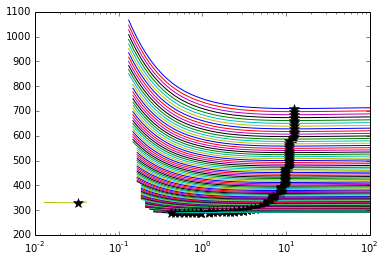

In [25]:
J_array = np.linspace(17,22,200)
J_new   = np.empty([0])
min_LikeJ  = np.empty([0])
min_r0_arr = np.empty([0])
min_b_arr  = np.empty([0])

for J in J_array:                                                # scan over an array of J values
    b_new   = np.empty([0])
    r0_new  = np.empty([0])
    LikeJr0 = np.empty([0])
    for j,r0 in enumerate(r0_array):                             # for each J scan over an array of r0 values
        LikeJb = np.zeros_like(beta_array)
        for i in range(beta_array.size): LikeJb[i] = logLike(10**J,i,j)
        interp_Like_b = interp(beta_array,LikeJb)                  # build the profile likelihood along ra
        
        eval_Like_b = np.linspace(beta_array.min(),beta_array.max(),1e3)
        min_Like_b  = interp_Like_b(eval_Like_b).min()
        min_b       = eval_Like_b[np.where(interp_Like_b(eval_Like_b)==min_Like_b)[0][0]]
        
        if beta_array[1]<min_b<beta_array[-2]:
            LikeJr0 = np.append(LikeJr0,min_Like_b)
            b_new   = np.append(b_new,min_b)
            r0_new  = np.append(r0_new,r0)
    
    if LikeJr0.size>3:
        interp_b  = interp(r0_new,b_new)
        interp_r0 = interp(r0_new,LikeJr0)                  # build the profile likelihood along r0
        
        eval_Like_r0 = np.logspace(log10(r0_new.min()),log10(r0_new.max()),1e3)
        min_Like_r0  = interp_r0(eval_Like_r0).min()
        min_r0       = eval_Like_r0[np.where(interp_r0(eval_Like_r0)==min_Like_r0)[0][0]]
        
        if r0_new[1]<min_r0<r0_new[-2]:
            plt.semilogx(r0_new,interp_r0(r0_new),label='J=%.2f'%J)
            plt.plot(min_r0,min_Like_r0,'*',markersize=10,c='k')
            
            min_b_arr  = np.append(min_b_arr,interp_b(min_r0))
            min_r0_arr = np.append(min_r0_arr,min_r0)
            min_LikeJ  = np.append(min_LikeJ,min_Like_r0)
            J_new      = np.append(J_new,J)

#plt.ylim(310,330)
#plt.xlim(1e-2,1e0)
#plt.legend(bbox_to_anchor=(1.4,1))

min J =  19.56  , r0 =  0.477  , beta =  -1.985


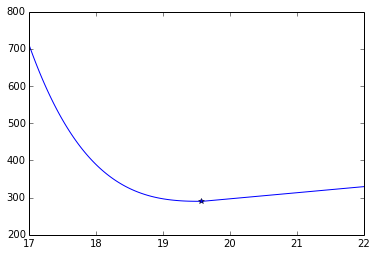

In [26]:
interp_Like_J  = interp(J_new,min_LikeJ)
interp_Like_b  = interp(J_new,min_b_arr)
interp_Like_r0 = interp(J_new,min_r0_arr)

eval_Like_J = np.linspace(J_new.min(),J_new.max(),1e3)
min_Like_J  = interp_Like_J(eval_Like_J).min()
J_min       = eval_Like_J[np.where(interp_Like_J(eval_Like_J)==min_Like_J)[0][0]]

J_b    = float(interp_Like_b(J_min))
J_r0   = float(interp_Like_r0(J_min))
J_rho0 = 10**sciopt.minimize_scalar(lambda log10rho0 : abs(J_min-np.log10(Jfactor(D,np.inf,J_r0,1.,theta))-2*log10rho0)).x

print 'min J = ',round(J_min,2),' , r0 = ',round(J_r0,3),' , beta = ',round(J_b,3)
plt.plot(J_new,interp_Like_J(J_new))
plt.plot(J_min,interp_Like_J(J_min),'b*')
#plt.ylim(240,260)

In [27]:
def one_sigmaJ(J):
    return np.abs(interp_Like_J(J)-interp_Like_J(J_min)-0.5)

one_sigma_l = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',bounds=(J_new[0],J_min)).x-J_min
one_sigma_r = sciopt.minimize_scalar(one_sigmaJ,method='Bounded',bounds=(J_min,J_new[-1])).x-J_min

def two_sigmaJ(J):
    return np.abs(interp_Like_J(J)-interp_Like_J(J_min)-2.)

two_sigma_l = sciopt.minimize_scalar(two_sigmaJ,method='Bounded',bounds=(J_new[0],J_min)).x-J_min
two_sigma_r = sciopt.minimize_scalar(two_sigmaJ,method='Bounded',bounds=(J_min,J_new[-1])).x-J_min

def three_sigmaJ(J):
    return np.abs(interp_Like_J(J)-interp_Like_J(J_min)-4.)

three_sigma_l = sciopt.minimize_scalar(three_sigmaJ,method='Bounded',bounds=(J_new[0],J_min)).x-J_min
three_sigma_r = sciopt.minimize_scalar(three_sigmaJ,method='Bounded',bounds=(J_min,J_new[-1])).x-J_min


In [28]:
print round(J_min,2),round(one_sigma_l,2),round(one_sigma_r,2),round(two_sigma_l,2),\
round(two_sigma_r,2),round(three_sigma_l,2),round(three_sigma_r,2)

19.56 -0.2 0.06 -0.35 0.15 -0.46 0.27


In [29]:
true_rho0 = 4e8 if mod == 1 or mod == 2 else 6.4e7
trueJ = round(np.log10(Jfactor(D,np.inf,1.,true_rho0,0.5)),2)
print 'true J : ',trueJ,', obtained J : ',round(J_min,2)

true J :  19.36 , obtained J :  19.56


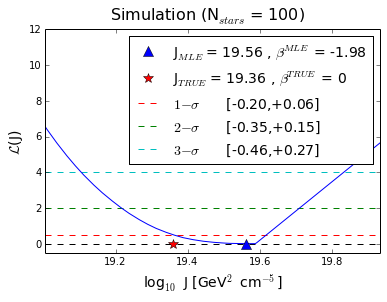

In [30]:
if J_min+three_sigma_l-0.1>J_new[0]: J_i = J_min+three_sigma_l-0.1
else: J_i = J_new[0]
if J_min+three_sigma_r+0.1<J_new[-1]: J_f = J_min+three_sigma_r+0.1
else: J_f = J_new[-1]

J_plt = np.linspace(J_i,J_f,200)
plt.plot(J_plt,interp_Like_J(J_plt)-interp_Like_J(J_min))
plt.plot(J_min,0,'b^',markersize=10,label='J$_{MLE}$ = %.2f'%J_min+r' , $\beta^{MLE}$ = %.2f'%J_b)
plt.plot(trueJ,0,'r*',markersize=10,label='J$_{TRUE}$ = %.2f'%trueJ+r' , $\beta^{TRUE}$ = 0')
plt.hlines(0.,min(J_plt),max(J_plt),linestyles='dashed')
plt.hlines(.5,min(J_plt),max(J_plt),colors=('r'),linestyles='dashed',
           label=r'$1-\sigma$'+'\t'+'[%.2f,%+.2f]'%(one_sigma_l,one_sigma_r))
plt.hlines(2,min(J_plt),max(J_plt),colors=('g'),linestyles='dashed',
           label=r'$2-\sigma$'+'\t'+'[%.2f,%+.2f]'%(two_sigma_l,two_sigma_r))
plt.hlines(4,min(J_plt),max(J_plt),colors=('c'),linestyles='dashed',
           label=r'$3-\sigma$'+'\t'+'[%.2f,%+.2f]'%(three_sigma_l,three_sigma_r))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.ylabel(r'$\mathcal{L}$(J)',fontsize=14)
plt.xlabel(r'log$_{10}$  J [GeV$^2$ cm$^{-5}$]',fontsize=14)
plt.ylim(-0.5,12)
plt.xlim(J_i,J_f)
#nstars=100
#plt.savefig(homedir+casedir[mod-1]+'/Sim%i_%s.png'%(nstars,casedir[mod-1]),dpi=300,format='png')
plt.suptitle(r'Simulation (N$_{stars}$ = %i)'%nstars,fontsize=16)
#plt.savefig(homedir+casedir[mod-1]+'/Sim%i_%s_title.png'%(nstars,casedir[mod-1]),dpi=300,format='png')

In [33]:
print '%5s %10s %10s'%('','True','Best fit')
print '%5s %10.2f %10.2f'%('r0',1.,J_r0)
print '%5s %10.2f %10.2f'%('ra',0.,J_b)
print '%5s %10.2e %10.2e'%('rho0',4e8 if mod == 1 or mod == 2 else 6.4e7,J_rho0)

            True   Best fit
   r0       1.00       0.95
   ra       0.00      -0.79
 rho0   6.40e+07   7.08e+07
